## CLARA multicore scaling

In [1]:
import json
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.autolayout'] = True

### Parameters

In [2]:
params = {
    'date': '2022-07-29',
    'host': 'nid006360',
    'chain': ['MAGFIELDS', 'FTCAL', 'FTHODO', 'FTEB', 'DCCR', 'MLTD', 'DCHAI', 'FTOFHB', 'EC', 'CVTFP', 'CTOF', 'CND', 'BAND', 'HTCC', 'LTCC', 'EBHB', 'DCTB', 'FMT', 'CVTSP', 'FTOFTB', 'EBTB', 'RICH', 'RTPC'],
    'input_file': './clas_006302.evio.00005-00009.hipo',
    'output_file': '/pscratch/sd/t/tylern/clas12/recon/test.hipo',
    'n_events': '2000',
    'jvm_options': ''
}

print(json.dumps(params, indent=4))

{
    "date": "2022-07-29",
    "host": "nid006360",
    "chain": [
        "MAGFIELDS",
        "FTCAL",
        "FTHODO",
        "FTEB",
        "DCCR",
        "MLTD",
        "DCHAI",
        "FTOFHB",
        "EC",
        "CVTFP",
        "CTOF",
        "CND",
        "BAND",
        "HTCC",
        "LTCC",
        "EBHB",
        "DCTB",
        "FMT",
        "CVTSP",
        "FTOFTB",
        "EBTB",
        "RICH",
        "RTPC"
    ],
    "input_file": "./clas_006302.evio.00005-00009.hipo",
    "output_file": "/pscratch/sd/t/tylern/clas12/recon/test.hipo",
    "n_events": "2000",
    "jvm_options": ""
}


### Benchmark

In [3]:
benchmark_data = """\
Cores,READER,MAGFIELDS,FTCAL,FTHODO,FTEB,DCCR,MLTD,DCHAI,FTOFHB,EC,CVTFP,CTOF,CND,BAND,HTCC,LTCC,EBHB,DCTB,FMT,CVTSP,FTOFTB,EBTB,RICH,RTPC,WRITER,TOTAL,Orchestrator
1,0.07,0.01,0.07,0.15,0.04,21.92,15.64,47.02,1.57,0.95,151.88,1.02,0.47,0.03,0.05,0.04,0.49,150.83,0.02,16.02,1.65,0.98,0.35,0.02,3.54,414.85,423.59
2,0.07,0.01,0.07,0.16,0.04,24.42,27.21,65.11,2.01,1.22,174.01,1.23,0.49,0.03,0.05,0.03,0.54,167.90,0.02,17.91,1.86,1.06,0.35,0.02,3.67,489.53,249.26
4,0.08,0.02,0.09,0.18,0.05,29.87,30.54,73.96,2.35,1.42,208.95,1.62,0.61,0.02,0.05,0.05,0.58,201.88,0.02,21.48,2.32,1.19,0.38,0.02,3.84,581.56,147.76
6,0.07,0.01,0.09,0.23,0.05,32.49,30.14,76.48,2.43,1.45,226.02,1.57,0.62,0.02,0.05,0.03,0.65,219.65,0.02,23.23,2.49,1.25,0.39,0.02,3.91,623.34,105.71
8,0.06,0.02,0.08,0.20,0.05,34.78,29.74,77.99,2.63,1.50,236.42,1.81,0.67,0.03,0.05,0.03,0.67,228.09,0.02,24.55,2.52,1.34,0.42,0.02,3.93,647.61,82.58
10,0.07,0.02,0.10,0.21,0.05,36.10,29.96,80.56,2.41,1.55,246.65,1.81,0.66,0.02,0.04,0.03,0.67,237.03,0.02,25.44,2.53,1.37,0.34,0.02,3.95,671.62,68.53
12,0.08,0.02,0.08,0.20,0.04,37.50,31.96,82.69,2.47,1.55,254.84,1.62,0.71,0.02,0.05,0.03,0.63,245.35,0.02,26.28,2.33,1.33,0.40,0.02,3.96,694.20,59.14
14,0.07,0.01,0.09,0.20,0.04,38.25,31.91,83.77,2.46,1.60,259.66,1.80,0.67,0.03,0.05,0.03,0.70,248.63,0.02,26.39,2.62,1.34,0.38,0.01,4.04,704.77,51.74
16,0.08,0.01,0.11,0.23,0.05,39.21,34.01,84.48,2.60,1.58,264.21,1.68,0.66,0.03,0.06,0.03,0.65,252.61,0.02,27.99,2.49,1.42,0.42,0.02,4.01,718.68,46.39
18,0.09,0.01,0.10,0.23,0.06,40.53,35.08,87.14,2.74,1.63,271.86,1.99,0.75,0.02,0.04,0.04,0.68,262.40,0.03,27.92,2.77,1.49,0.42,0.02,4.16,742.19,42.73
20,0.09,0.02,0.10,0.22,0.05,39.89,36.08,84.78,2.65,1.57,266.42,1.96,0.68,0.03,0.05,0.04,0.74,255.16,0.03,27.54,2.53,1.49,0.40,0.01,4.13,726.66,37.91
22,0.10,0.02,0.09,0.20,0.04,39.63,37.11,84.30,2.88,1.62,261.73,1.77,0.76,0.02,0.06,0.03,0.80,258.84,0.03,26.57,2.69,1.42,0.43,0.02,4.16,725.33,34.60
24,0.08,0.02,0.10,0.18,0.04,37.92,34.89,82.58,2.75,1.57,257.79,1.89,0.64,0.03,0.06,0.03,0.72,244.62,0.02,26.15,2.55,1.42,0.43,0.02,4.09,700.59,30.79
26,0.08,0.01,0.08,0.22,0.05,42.07,37.30,88.32,2.79,1.80,276.84,2.38,0.79,0.03,0.06,0.03,0.72,258.08,0.03,27.52,2.75,1.53,0.41,0.02,4.26,748.17,30.55
28,0.08,0.01,0.10,0.23,0.05,43.86,41.47,92.02,2.74,1.88,288.16,2.34,0.78,0.02,0.04,0.04,0.80,274.25,0.03,29.08,2.82,1.61,0.42,0.01,4.32,787.16,29.89
30,0.08,0.02,0.10,0.24,0.05,43.46,41.10,94.01,2.72,1.78,288.76,2.16,0.83,0.03,0.04,0.03,0.79,274.38,0.02,29.21,2.94,1.54,0.45,0.02,4.25,788.99,28.09
32,0.09,0.01,0.11,0.25,0.05,44.40,41.05,94.32,2.71,1.91,292.64,2.12,0.84,0.03,0.05,0.04,0.76,276.64,0.02,28.84,2.97,1.71,0.46,0.02,4.39,796.40,26.72
34,0.10,0.02,0.11,0.26,0.07,45.46,44.72,96.80,3.10,1.89,296.48,2.41,0.84,0.02,0.06,0.05,0.85,275.72,0.03,29.55,3.18,1.77,0.45,0.02,4.36,808.32,25.72
36,0.10,0.01,0.11,0.26,0.06,46.93,47.64,97.44,2.85,2.03,299.09,2.33,0.89,0.03,0.06,0.05,0.86,282.35,0.03,30.54,3.40,1.65,0.48,0.02,4.41,823.62,24.84
38,0.09,0.02,0.13,0.24,0.05,45.82,47.41,96.55,2.97,2.04,301.43,2.02,0.83,0.03,0.06,0.04,0.77,278.69,0.03,29.88,3.02,1.67,0.50,0.02,4.49,818.80,23.53
40,0.13,0.02,0.16,0.31,0.05,48.05,57.20,99.25,3.37,2.16,310.29,2.44,0.97,0.03,0.07,0.05,0.88,289.59,0.03,31.77,3.67,1.83,0.58,0.02,4.51,857.45,23.44
42,0.12,0.02,0.15,0.30,0.06,48.99,55.60,101.84,3.52,2.24,313.13,3.16,0.99,0.03,0.08,0.05,0.96,288.80,0.03,31.07,3.81,1.88,0.57,0.02,4.52,861.93,22.54
44,0.10,0.02,0.13,0.29,0.09,48.89,56.72,102.19,3.72,2.23,314.76,2.57,1.00,0.04,0.07,0.04,0.91,287.43,0.03,31.56,3.88,1.97,0.57,0.02,4.71,863.96,21.75
46,0.13,0.02,0.10,0.27,0.05,49.30,57.07,101.73,3.72,2.24,315.57,3.14,0.88,0.03,0.07,0.06,0.94,290.16,0.03,30.69,3.90,1.90,0.54,0.02,4.61,867.15,20.93
48,0.10,0.04,0.14,0.30,0.07,49.30,56.49,104.38,3.18,2.25,316.18,2.37,0.89,0.03,0.07,0.05,0.92,292.40,0.03,31.23,3.66,1.88,0.55,0.02,4.63,871.15,20.32
50,0.10,0.02,0.13,0.29,0.07,50.33,55.53,106.25,3.54,2.28,320.70,2.56,0.99,0.03,0.08,0.06,0.95,293.58,0.03,31.49,3.67,1.96,0.52,0.02,4.66,879.86,19.76
52,0.09,0.02,0.15,0.32,0.05,51.71,55.36,107.08,3.40,2.25,320.59,2.78,0.96,0.03,0.09,0.05,0.98,294.76,0.03,31.28,3.60,1.91,0.64,0.03,4.65,882.80,19.11
54,0.11,0.02,0.13,0.32,0.06,51.50,59.63,108.87,3.70,2.36,329.85,3.31,0.95,0.05,0.07,0.06,0.98,303.10,0.03,32.29,3.86,2.05,0.62,0.03,4.73,908.68,18.98
56,0.11,0.02,0.14,0.32,0.06,51.43,60.41,108.77,3.86,2.28,331.00,2.87,1.02,0.04,0.06,0.04,1.01,303.61,0.03,32.67,3.79,2.10,0.60,0.03,4.78,911.05,18.46
58,0.10,0.03,0.15,0.31,0.08,50.29,58.63,107.20,4.03,2.29,327.48,2.93,1.01,0.03,0.08,0.06,1.08,299.87,0.04,32.34,4.15,2.02,0.64,0.03,4.84,899.66,17.70
60,0.13,0.02,0.14,0.35,0.08,51.00,62.45,109.17,4.09,2.51,329.65,3.21,1.10,0.04,0.08,0.06,1.06,302.87,0.04,32.43,4.28,2.09,0.70,0.03,4.89,912.44,17.40
62,0.12,0.03,0.15,0.33,0.07,52.01,64.62,110.41,4.01,2.56,333.63,3.18,1.11,0.04,0.09,0.06,1.05,304.27,0.04,33.02,4.24,2.10,0.65,0.03,4.94,922.76,17.10
64,0.12,0.02,0.14,0.35,0.08,52.54,59.12,111.97,4.16,2.63,336.67,3.53,1.03,0.04,0.08,0.06,1.00,308.80,0.03,33.25,4.28,2.16,0.65,0.03,4.89,927.64,16.66
66,0.16,0.02,0.16,0.38,0.08,53.79,62.53,112.82,4.04,2.52,338.97,3.30,1.16,0.03,0.08,0.05,1.11,312.74,0.05,33.51,4.42,2.23,0.68,0.03,4.99,939.85,16.46
68,0.13,0.03,0.14,0.34,0.08,53.63,61.71,114.22,3.85,2.52,343.96,3.26,1.08,0.04,0.08,0.07,1.08,318.09,0.04,33.74,3.84,2.16,0.71,0.03,5.03,949.83,16.22
70,0.13,0.03,0.18,0.45,0.12,56.96,67.84,119.44,4.31,2.74,350.95,3.34,1.25,0.04,0.13,0.06,1.14,322.43,0.04,34.44,4.52,2.27,0.74,0.03,5.26,978.82,16.32
72,0.16,0.03,0.16,0.41,0.08,58.20,70.88,120.80,4.22,2.79,359.63,3.40,1.22,0.04,0.10,0.06,1.20,332.22,0.04,35.19,4.45,2.41,0.71,0.03,5.20,1003.63,16.33
74,0.20,0.02,0.16,0.38,0.10,58.26,75.74,120.70,4.30,2.71,360.54,3.72,1.26,0.04,0.09,0.06,1.25,330.33,0.04,35.06,4.68,2.27,0.67,0.04,5.25,1007.90,16.06
76,0.14,0.03,0.18,0.42,0.09,59.12,72.98,122.59,4.60,2.86,364.20,3.22,1.21,0.04,0.09,0.06,1.27,333.32,0.04,35.83,4.57,2.35,0.69,0.04,5.36,1015.31,15.80
78,0.16,0.02,0.22,0.48,0.09,59.25,76.98,124.00,4.49,3.11,368.23,4.21,1.32,0.05,0.13,0.07,1.41,338.04,0.04,36.06,4.72,2.44,0.82,0.03,5.34,1031.71,15.71
80,0.19,0.02,0.19,0.43,0.12,60.72,77.13,123.07,4.92,3.05,374.85,3.93,1.34,0.04,0.10,0.07,1.31,342.20,0.04,36.38,4.75,2.53,0.84,0.04,5.44,1043.72,15.56
82,0.16,0.03,0.21,0.51,0.09,61.02,72.51,126.04,5.12,3.04,376.06,4.74,1.39,0.04,0.12,0.07,1.34,343.20,0.04,36.75,5.25,2.57,0.77,0.03,5.44,1046.54,15.30
84,0.16,0.03,0.20,0.47,0.10,63.12,73.35,127.91,4.71,3.03,381.21,4.22,1.38,0.05,0.10,0.07,1.40,349.49,0.04,36.97,4.90,2.53,0.76,0.03,5.42,1061.65,15.12
86,0.14,0.03,0.20,0.47,0.12,63.88,72.96,129.70,4.94,3.13,393.14,4.40,1.49,0.05,0.11,0.08,1.54,359.70,0.04,37.99,5.41,2.71,0.91,0.04,5.52,1088.71,15.15
88,0.15,0.03,0.22,0.53,0.13,63.86,79.97,129.56,4.95,3.16,392.35,4.64,1.56,0.05,0.10,0.08,1.53,359.78,0.05,38.40,5.39,2.84,0.96,0.04,5.60,1095.91,15.02
90,0.17,0.02,0.23,0.59,0.11,61.60,81.46,126.95,5.56,3.53,392.96,5.40,1.79,0.05,0.13,0.09,1.79,360.06,0.05,38.90,6.22,2.95,1.04,0.04,5.61,1097.32,14.79
92,0.20,0.03,0.29,0.75,0.15,67.39,94.95,133.94,6.11,4.13,405.81,6.77,1.97,0.06,0.16,0.09,2.15,374.56,0.06,40.17,6.41,3.31,1.13,0.05,5.73,1156.36,15.30
94,0.22,0.02,0.27,0.70,0.15,67.25,88.35,135.76,5.75,3.93,414.75,5.69,1.95,0.05,0.15,0.11,2.09,382.21,0.04,40.48,6.41,3.12,1.14,0.04,5.84,1166.48,15.12
96,0.26,0.03,0.29,0.75,0.16,67.77,89.33,135.91,5.88,3.97,420.43,5.97,2.15,0.05,0.16,0.11,2.16,383.42,0.05,41.96,6.37,3.15,1.19,0.04,5.84,1177.38,15.02
98,0.20,0.02,0.29,0.75,0.17,68.65,88.23,134.34,5.61,3.75,418.45,6.07,2.08,0.05,0.14,0.10,2.19,382.86,0.04,42.10,6.73,3.23,1.13,0.04,5.88,1173.12,14.80
100,0.22,0.02,0.34,0.75,0.20,70.69,83.34,136.56,6.04,4.25,424.02,7.00,2.35,0.06,0.15,0.13,2.37,389.07,0.04,42.67,7.14,3.30,1.19,0.04,5.82,1187.74,14.69
102,0.23,0.03,0.35,0.85,0.16,72.96,87.73,137.26,6.15,4.29,429.14,6.63,2.60,0.07,0.17,0.12,2.35,393.61,0.04,43.22,7.11,3.41,1.35,0.04,5.82,1205.72,14.69
104,0.24,0.02,0.35,0.80,0.17,70.02,84.05,136.93,6.29,4.45,430.20,6.76,2.59,0.07,0.16,0.14,2.59,393.81,0.04,43.93,7.17,3.38,1.33,0.04,5.91,1201.42,14.48
106,0.24,0.02,0.38,0.93,0.18,70.39,85.20,135.43,6.45,4.54,429.97,7.39,2.87,0.07,0.16,0.15,2.83,392.72,0.04,44.49,7.86,3.63,1.37,0.04,6.05,1203.41,14.33
108,0.23,0.02,0.40,0.97,0.22,69.84,94.47,137.17,6.95,5.11,439.17,8.91,3.14,0.06,0.23,0.14,3.01,401.61,0.04,45.03,7.98,3.71,1.30,0.04,6.05,1235.78,14.50
110,0.22,0.02,0.45,1.06,0.22,73.16,84.47,138.02,7.18,5.06,445.85,8.67,3.55,0.06,0.20,0.15,3.06,403.76,0.04,46.52,8.76,3.54,1.54,0.03,6.11,1241.71,14.32
112,0.28,0.02,0.47,1.04,0.20,78.68,92.34,145.79,7.74,5.55,459.82,8.92,3.69,0.06,0.22,0.16,3.39,418.47,0.04,47.21,8.83,4.02,1.47,0.03,6.25,1294.69,14.74
114,0.25,0.02,0.41,1.16,0.27,79.50,96.14,146.46,8.38,6.16,467.93,9.38,3.86,0.12,0.25,0.19,3.71,424.98,0.05,48.63,9.49,3.94,1.70,0.04,6.45,1319.47,14.79
116,0.30,0.02,0.48,1.15,0.25,80.25,92.49,150.55,8.72,6.37,473.96,10.01,4.48,0.09,0.21,0.18,4.16,425.94,0.04,49.01,9.58,4.17,1.67,0.05,6.21,1330.34,14.72
118,0.30,0.02,0.53,1.45,0.31,83.59,99.41,151.86,10.13,7.31,483.23,11.65,4.65,0.07,0.30,0.23,4.63,434.15,0.05,51.55,10.78,4.76,1.86,0.04,6.43,1369.27,14.92
120,0.32,0.02,0.60,1.55,0.32,85.83,107.33,147.76,10.24,7.23,486.56,11.76,5.29,0.08,0.26,0.26,4.83,440.28,0.04,51.16,10.53,4.84,1.95,0.05,6.55,1385.65,14.95
122,0.31,0.02,0.76,1.92,0.42,87.47,108.86,156.99,12.72,9.86,502.19,13.45,6.56,0.08,0.37,0.28,6.02,454.18,0.05,56.45,13.90,6.02,2.43,0.07,6.44,1447.81,15.29
124,0.41,0.03,0.84,2.19,0.49,93.25,119.70,164.98,14.11,11.19,516.27,13.71,7.48,0.10,0.37,0.26,6.68,464.65,0.04,58.36,13.99,5.82,2.33,0.06,6.47,1503.80,15.67
126,0.39,0.02,0.80,1.99,0.44,94.42,110.76,166.66,14.77,10.98,523.08,14.25,7.48,0.12,0.37,0.22,6.40,472.20,0.05,58.66,14.20,5.68,2.46,0.05,6.69,1513.14,15.58
128,0.49,0.02,0.77,1.95,0.45,91.34,126.03,164.82,14.64,11.13,527.00,12.93,6.96,0.10,0.33,0.26,6.17,475.54,0.04,58.67,13.07,5.40,2.31,0.05,6.74,1527.19,15.62"""

df = pd.read_csv(StringIO(benchmark_data))

In [4]:
df['EvRate'] = 1000 / df['Orchestrator']

pd.options.display.max_columns = None
pd.options.display.precision = 2
df

,Cores,READER,MAGFIELDS,FTCAL,FTHODO,FTEB,DCCR,MLTD,DCHAI,FTOFHB,EC,CVTFP,CTOF,CND,BAND,HTCC,LTCC,EBHB,DCTB,FMT,CVTSP,FTOFTB,EBTB,RICH,RTPC,WRITER,TOTAL,Orchestrator,EvRate
0,1,0.07,0.01,0.07,0.15,0.04,21.92,15.64,47.02,1.57,0.95,151.88,1.02,0.47,0.03,0.05,0.04,0.49,150.83,0.02,16.02,1.65,0.98,0.35,0.02,3.54,414.85,423.59,2.36
1,2,0.07,0.01,0.07,0.16,0.04,24.42,27.21,65.11,2.01,1.22,174.01,1.23,0.49,0.03,0.05,0.03,0.54,167.90,0.02,17.91,1.86,1.06,0.35,0.02,3.67,489.53,249.26,4.01
2,4,0.08,0.02,0.09,0.18,0.05,29.87,30.54,73.96,2.35,1.42,208.95,1.62,0.61,0.02,0.05,0.05,0.58,201.88,0.02,21.48,2.32,1.19,0.38,0.02,3.84,581.56,147.76,6.77
3,6,0.07,0.01,0.09,0.23,0.05,32.49,30.14,76.48,2.43,1.45,226.02,1.57,0.62,0.02,0.05,0.03,0.65,219.65,0.02,23.23,2.49,1.25,0.39,0.02,3.91,623.34,105.71,9.46
4,8,0.06,0.02,0.08,0.20,0.05,34.78,29.74,77.99,2.63,1.50,236.42,1.81,0.67,0.03,0.05,0.03,0.67,228.09,0.02,24.55,2.52,1.34,0.42,0.02,3.93,647.61,82.58,12.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,120,0.32,0.02,0.60,1.55,0.32,85.83,107.33,147.76,10.24,7.23,486.56,11.76,5.29,0.08,0.26,0.26,4.83,440.28,0.04,51.16,10.53,4.84,1.95,0.05,6.55,1385.65,14.95,66.89
61,122,0.31,0.02,0.76,1.92,0.42,87.47,108.86,156.99,12.72,9.86,502.19,13.45,6.56,0.08,0.37,0.28,6.02,454.18,0.05,56.45,13.90,6.02,2.43,0.07,6.44,1447.81,15.29,65.40
62,124,0.41,0.03,0.84,2.19,0.49,93.25,119.70,164.98,14.11,11.19,516.27,13.71,7.48,0.10,0.37,0.26,6.68,464.65,0.04,58.36,13.99,5.82,2.33,0.06,6.47,1503.80,15.67,63.82
63,126,0.39,0.02,0.80,1.99,0.44,94.42,110.76,166.66,14.77,10.98,523.08,14.25,7.48,0.12,0.37,0.22,6.40,472.20,0.05,58.66,14.20,5.68,2.46,0.05,6.69,1513.14,15.58,64.18


### Plots

In [5]:
title = 'Scaling test - CLARA 4.3-SNAPSHOT - nid006360 - 2000 events'
xlim = (0, 130)
xticks = range(0, 130, 4)

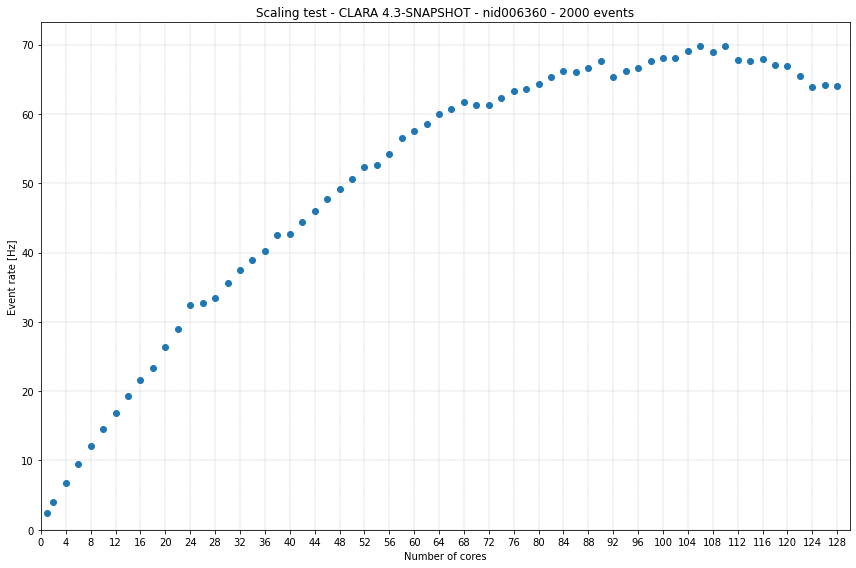

In [6]:
ax = df.plot(x='Cores', y='EvRate', style='o', legend=False, xlim=xlim, xticks=xticks)
ax.set_title(title)
ax.set_ylim(bottom=0)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Event rate [Hz]');

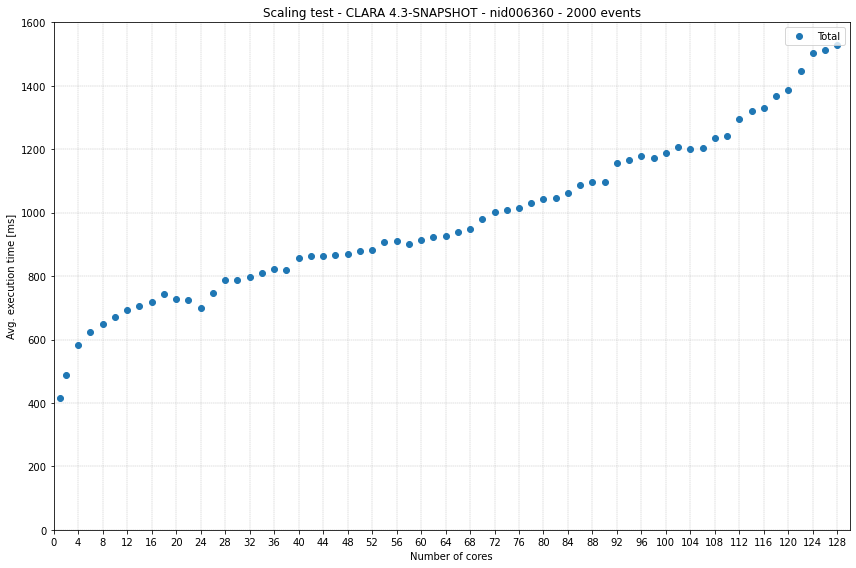

In [7]:
_, ax = plt.subplots()

df.plot(x='Cores', y='TOTAL', ax=ax, label='Total', style='o')

ax.set_title(title)
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(0, 1600)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Avg. execution time [ms]')
ax.legend();